In [1]:
#!git clone https://github.com/darioka/impactdeal-2022.git
#%cd impactdeal-2022
#!pip install -r requirements.txt
#!pip install .

# Logistic Regression

Here we are going to apply the `scikit-learn` implementation of the [logistic regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression) model to the Adult dataset, both with numerical and categorical features.

[Logistic regressions](https://en.wikipedia.org/wiki/Logistic_regression) belong to the group of linear models, like [linear regressions](https://en.wikipedia.org/wiki/Linear_regression). Linear models can be represented by simple formulas where a set of **weights** $\beta$, estimated by the model, are linearly combined to features $x$ to predict the target variable:

$$
y = \beta_0 + \beta_1x_1+ ... + \beta_kx_k
$$

In our classification context, a logistic regression could say that if

```
1.25 + 0.4*age + 2.11*hours-per-week - 0.07*capital-loss
```

is greater that 0.5 the we should predict `>50K`, otherwise we should predict `<=50K`. One of the most important point of linear models is that looking at their weights we could learn what is the impact of features in predicting the target.


## Table of Contents

1. [Loading and splitting](#Loading-and-splitting)
2. [Data preprocessing](#Data-preprocessing)
3. [Model fitting and evaluation](#Model-evaluation-and-evaluation)
4. [Model interpretation](#Model-interpretation)
5. [Conclusion](#Conclusion)

## Loading and splitting

Let's apply the well known steps to load and split the adult dataset.

In [2]:
import pandas as pd

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split


# read the data
X, y = fetch_openml(data_id=1590, return_X_y=True, as_frame=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [3]:
X.dtypes

age                float64
workclass         category
fnlwgt             float64
education         category
education-num      float64
marital-status    category
occupation        category
relationship      category
race              category
sex               category
capital-gain       float64
capital-loss       float64
hours-per-week     float64
native-country    category
dtype: object

In [4]:
numerical_cols = ["age", "education-num", "capital-gain", "capital-loss", "hours-per-week"]
categorical_cols = ["workclass", "marital-status", "occupation", "relationship", "race", "sex"]

## Data Preprocessing

Training a good logistic regression requires careful preprocessing steps. In particular:

* **Outlier removal**: linear models are affected by the presence of distant numerical values. Even though for logistic regression the effect is less severe then for linear regression, they may still influence performances.

* **Standard Scaling**: the numerical optimization behind model training greatly benefits from having numerical features with mean zero and standard deviation equal to one.

* **One Hot Encoding**: categorical variables should be encoded without assuming a false ordering between them.

Note that the previous steps are not mandatory, and `python` will not complain or throws errors if you skip them. Everything would still work, but performances and preditions of the model coulb be greatly affected by our choices.

### Numerical features

If we look at the extreme values in our numerical variables, we see that `capital-gain` and `hours-per-week` contain values that are very distant from the rest of their distribution. Also, values like `99` or `99999` are suspicious, as in old softwares they could indicate missing values or data corruption.

Our choice will be to remove them from the training dataset.

<div class="alert alert-block alert-info">

Should we remove outliers from the test data?

</div>

In [5]:
X_train.describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.99, 0.999])

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,34189.000000,3.418900e+04,34189.000000,34189.000000,34189.000000,34189.000000
mean,38.707918,1.896518e+05,10.077510,1050.979526,89.103718,40.480710
std,13.713761,1.049828e+05,2.572106,7281.745072,406.099391,12.433999
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
10%,22.000000,6.627800e+04,7.000000,0.000000,0.000000,24.000000
25%,28.000000,1.177890e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.782820e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.374330e+05,12.000000,0.000000,0.000000,45.000000
99%,74.000000,5.096290e+05,16.000000,15024.000000,1980.000000,80.000000
99.9%,90.000000,7.890018e+05,16.000000,99999.000000,2559.000000,99.000000


In [6]:
outlier_filter = (X_train["capital-gain"] < 99) & (X_train["hours-per-week"] < 99999)

print(f"Number of rows: {X_train.shape[0]}")
X_train = X_train[outlier_filter]
y_train = y_train[outlier_filter]
print(f"Number of rows after outlier removal: {X_train.shape[0]}")

Number of rows: 34189
Number of rows after outlier removal: 31397


Let's move on with the next step.

[Standard Scaling](https://en.wikipedia.org/wiki/Feature_scaling) is a transformation of a numerical feature used to normalize the data around mean zero with unit standard deviation.

$$
x \longrightarrow \frac{x - \bar{x}}{\sigma},
$$

$$
\mathrm{where} \hspace{1em} \bar{x} = \frac{1}{N}\sum_{i=0}^Nx_i, \hspace{1em} \mathrm{and} \hspace{1em} \sigma = \frac{1}{N}\sqrt{\sum_{i=0}^N{\left(x_i - \bar{x}\right)}^2}
$$

In [7]:
# example
import numpy as np

test_data = np.array([2, 2, 4, 4, 6, 6])
print("Test data: {test_data}")
print(f"Mean: {test_data.mean()}")
print(f"Standard deviation: {test_data.std()}")
print()

new_test_data = (test_data - test_data.mean()) / test_data.std()
print(f"Transformed test data: {new_test_data}")
print(f"Mean: {new_test_data.mean()}")
print(f"Standard deviation: {new_test_data.std().round(2)}")

Test data: {test_data}
Mean: 4.0
Standard deviation: 1.632993161855452

Transformed test data: [-1.22474487 -1.22474487  0.          0.          1.22474487  1.22474487]
Mean: 0.0
Standard deviation: 1.0


`scikit-learn` [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) conveniently provided a simple way to do this transformation. Its `fit` method computes mean and standard deviation while `transform` applies the transformation. As always, remember that `fit` must be called on training data only.

In [8]:
from sklearn.preprocessing import StandardScaler

num_X_train = X_train[numerical_cols]
num_X_test = X_test[numerical_cols]

sc = StandardScaler()
sc.fit(num_X_train)

num_X_train = pd.DataFrame(sc.transform(num_X_train), columns=numerical_cols, index=num_X_train.index)
num_X_test = pd.DataFrame(sc.transform(num_X_test), columns=numerical_cols, index=num_X_test.index)

num_X_train

,age,education-num,capital-gain,capital-loss,hours-per-week
38865,-1.262687,-0.389405,0.0,-0.229457,1.597559
17212,-1.409222,0.003542,0.0,-0.229457,-2.441227
9312,-0.456746,-0.389405,0.0,-0.229457,0.385924
15512,-0.236944,1.182384,0.0,-0.229457,-0.017955
23576,-1.262687,0.789436,0.0,-0.229457,-0.421834
...,...,...,...,...,...
16180,-0.823083,1.575331,0.0,-0.229457,-1.633469
42096,1.081867,1.182384,0.0,-0.229457,0.305148
29457,0.349194,-0.389405,0.0,-0.229457,0.143596
20602,-0.456746,-0.389405,0.0,-0.229457,-0.017955


### Categorical features

For a categorical column, [one-hot encoding]() creates as many new columns as there are categories, and sets their values to zero when the sample belongs to the corresponding category and zero otherwise.

Let's first make an example and then apply `scikit-learn` [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) to our dataset.

In [9]:
from sklearn.preprocessing import OneHotEncoder

test_data = pd.DataFrame(["A", "B", "C", "A", "B"], columns=["x"])
test_data

,x
0,A
1,B
2,C
3,A
4,B


In [10]:
ohe = OneHotEncoder(sparse=False)
ohe.fit(test_data)

pd.DataFrame(ohe.transform(test_data), columns=ohe.get_feature_names_out())

,x_A,x_B,x_C
0,1.0,0.0,0.0
1,0.0,1.0,0.0
2,0.0,0.0,1.0
3,1.0,0.0,0.0
4,0.0,1.0,0.0


In [11]:
ohe = OneHotEncoder(
    handle_unknown="ignore",  # if a category is missing, output all zeros
    sparse=False  # a sparse representation is more efficient for large datasets
)

ohe.fit(X_train[categorical_cols])

cat_X_train = pd.DataFrame(ohe.transform(X_train[categorical_cols]), columns=ohe.get_feature_names_out(), index=X_train.index)
cat_X_test = pd.DataFrame(ohe.transform(X_test[categorical_cols]), columns=ohe.get_feature_names_out(), index=X_test.index)

cat_X_train

,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Without-pay,workclass_nan,marital-status_Divorced,...,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Female,sex_Male
38865,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
17212,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
9312,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
15512,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
23576,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16180,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
42096,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
29457,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
20602,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [12]:
# finally, let's put everything together
preprocessed_X_train = pd.concat([num_X_train, cat_X_train], axis=1)
preprocessed_X_test = pd.concat([num_X_test, cat_X_test], axis=1)

preprocessed_X_train

,age,education-num,capital-gain,capital-loss,hours-per-week,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,...,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Female,sex_Male
38865,-1.262687,-0.389405,0.0,-0.229457,1.597559,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
17212,-1.409222,0.003542,0.0,-0.229457,-2.441227,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
9312,-0.456746,-0.389405,0.0,-0.229457,0.385924,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
15512,-0.236944,1.182384,0.0,-0.229457,-0.017955,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
23576,-1.262687,0.789436,0.0,-0.229457,-0.421834,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16180,-0.823083,1.575331,0.0,-0.229457,-1.633469,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
42096,1.081867,1.182384,0.0,-0.229457,0.305148,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
29457,0.349194,-0.389405,0.0,-0.229457,0.143596,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
20602,-0.456746,-0.389405,0.0,-0.229457,-0.017955,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


## Model fitting and evaluation

Now we will perform the same training and evaluation steps we did for the decision tree.

In [13]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(
    penalty="none",  # this is related to complexity and hyperparameters. More on this in future modules
    max_iter=500,  # numerical optimization runs until convergence or max_iter
)

model.fit(preprocessed_X_train, y_train)

LogisticRegression(max_iter=500, penalty='none')

              precision    recall  f1-score   support

        >50K       0.73      0.51      0.60      3506
       <=50K       0.86      0.94      0.90     11147

    accuracy                           0.84     14653
   macro avg       0.80      0.73      0.75     14653
weighted avg       0.83      0.84      0.83     14653



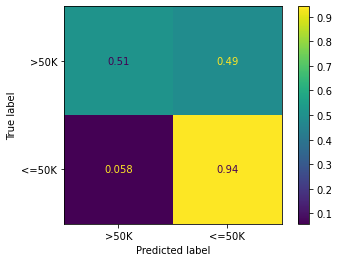

In [14]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

ConfusionMatrixDisplay.from_estimator(
    model, preprocessed_X_test, y_test, normalize="true", labels=[">50K", "<=50K"]
)

print(
    classification_report(y_test, model.predict(preprocessed_X_test), labels=[">50K", "<=50K"])
)

## Model interpretation

Logistic regression naturally outputs **probabilities**, i.e. we could not only predict which class a sample belongs to, but also how likely.

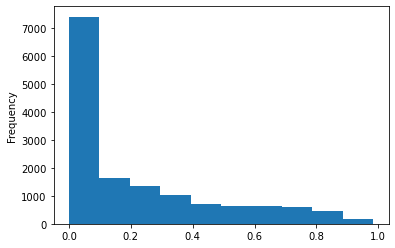

In [15]:
y_proba = model.predict_proba(preprocessed_X_test)[:, 1]
_ = pd.Series(y_proba).plot.hist()

In [16]:
# Can you extract the test samples with more than 95% probability of having >50K?

# Write here your code!

<div class="alert alert-block alert-info">

Actually, many models can outputs "scores" between 0 and 1. We need to be careful, though, if we want to interpret them as probabilities, as they not always behave like probabilities. This topic goes under the name of <a href="https://scikit-learn.org/stable/modules/calibration.html">model calibration</a>.

</div>

In addition to well-calibrated probabilities, a logistic regression allows us to inspect the relation between features and target. In fact, model fitting estimates a set of **weights** whose value directly measures the impact of a variable on the predicted output.

Let's take a look at some of the largest coefficients of our logistic regression.

<div class="alert alert-block alert-info">

What can we say about what the model has learned?

</div>

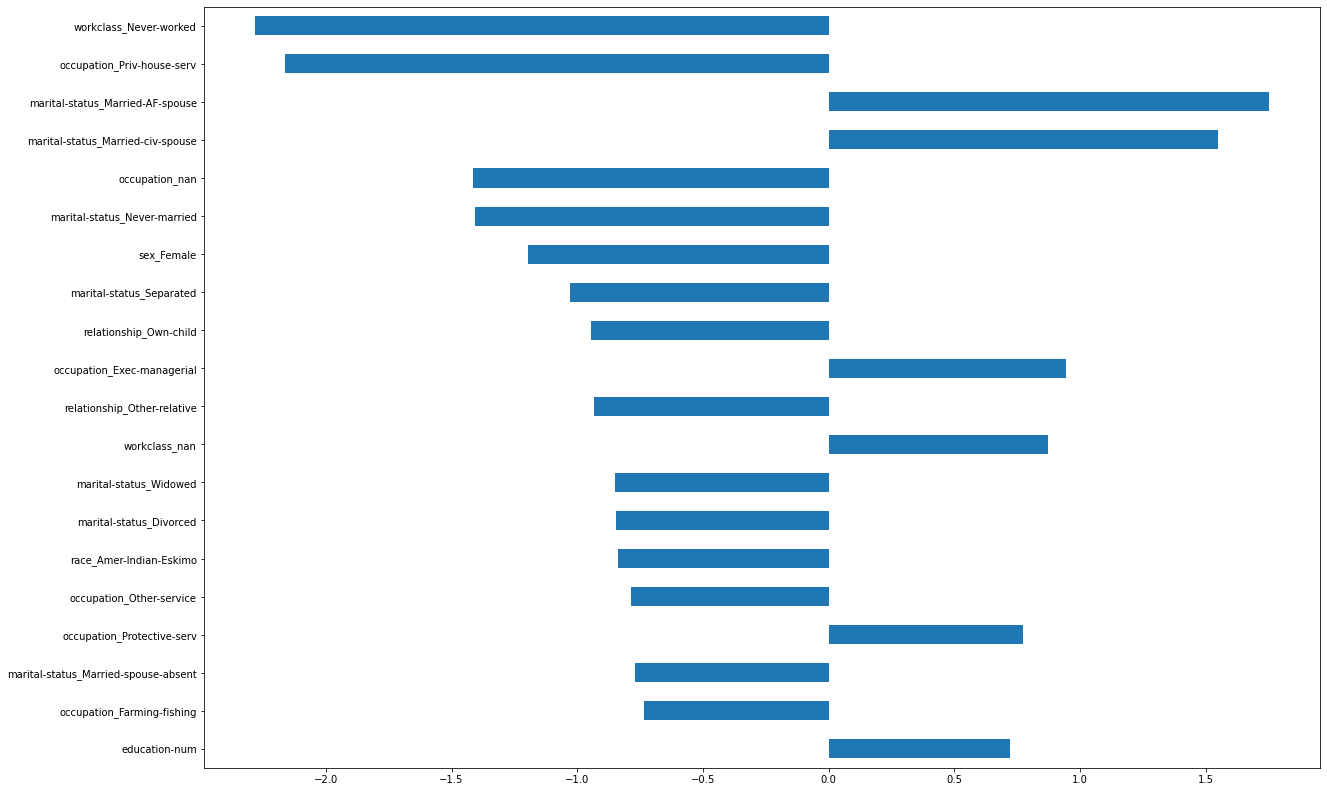

In [17]:
_ = pd.Series(
    model.coef_.reshape(-1), index=model.feature_names_in_ # array with weights of the model
).sort_values(
    key=abs  # sort by absolute value, then take the first 20 elements
).iloc[-20:].plot.barh(figsize=(20, 14))

## Conclusion

In this notebook we trained a logistic regression for the binary classification problem of the Adult dataset. We have learned:

* how to preprocess numerical data, removing outlier and applying normalization.
* How to preprocess categorical data with one-hot encoding.
* How to fit and evaluate a logistic regression model.
* How to outputs predicted probabilities and interpret the internal parameters of the model.